In [2]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

import a_matrix_analysis_lib as mat_ansys
import b_spin_representations as su2
import c_evs_visualization_tools as evs_visz_tools
import d_projected_evolution_dynamics as me
import e_Multiple_Max_Ent_evs as rme

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [48]:
N=6; chain_type = "XX"; k_B = 1; temp = 1e+1; temp_ref = 1e+1

### One body local spin operators
spin_ops_list = su2.one_body_spin_ops(size = N)
identity_op = spin_ops_list[0][0]/(2**3)

### Heisenberg Hamiltonian
Jx= .5; Jy = 1/5; Jz = 1/10
H_H = 0
H_H += .1 * sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
H_H += Jx*(spin_ops_list[1][0] * spin_ops_list[1][1] + spin_ops_list[1][1] * spin_ops_list[1][2]) 
H_H += Jy*(spin_ops_list[2][0] * spin_ops_list[2][1] + spin_ops_list[2][1] * spin_ops_list[2][2])  
H_H += Jz*(spin_ops_list[3][0] * spin_ops_list[3][1] + spin_ops_list[3][1] * spin_ops_list[3][2]) 

### Some observables of interest

cl_ops, label_ops = su2.classical_ops(size = N, Hamiltonian = H_H,
                                                op_list = spin_ops_list, centered_x_op = False)

magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
cl_ops["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; label_ops.append("n_oc_op_sq")
cl_ops["x_op"] = -.1 * (spin_ops_list[3][2] - spin_ops_list[3][0])

print("Are all the operators Hermitian?:", mat_ansys.basis_hermitian_check(basis = cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True, True]


In [49]:
# solo algunos observables
subset_of_observables = {}; subset_label_ops = []
subset_of_observables["x_op_sq"] = cl_ops["x_op"]**2; subset_label_ops.append("x_op_sq")
subset_of_observables["n_oc_op"] = cl_ops["n_oc_op"]; subset_label_ops.append("n_oc_op")
subset_of_observables["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; subset_label_ops.append("n_oc_op_sq")

In [50]:
cl_ops["x_op"] = -.1 * (spin_ops_list[3][2] - spin_ops_list[3][0])

K_ref = K0 = H_H + cl_ops["x_op"]
coeff_basis_t0 = [0, 1, 0, 1]
rho_ref = (-K_ref).expm()
rho_ref = rho_ref/rho_ref.tr()

calB_basis_0 = [identity_op, H_H, cl_ops["magnetization"]] # with the last number corresponding to cl_ops["x_op"]
range_derived_series_orders = depth_parameters = [0, 1, 2, 3, 4, 5, 6, 7, 8]
range_derived_series_orders = depth_parameters = [0, 1, 2, 3, 4, 5, 6, 7, 8]
all_coeff_list = [coeff_basis_t0 + list(np.zeros(a)) for a in depth_parameters]

In [51]:
depth_parameters

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [52]:
depth_and_seed_ops = [(1, op) for op in calB_basis_0] + [(4, cl_ops["x_op"])]
HBell5 = mat_ansys.vectorized_Hierarchical_Basis(depth_and_seed_ops, H_H, rho_ref = rho_ref)
print(len(HBell5))

HBell5_orth = mat_ansys.base_orth(ops = HBell5, 
                           rhoref = rho_ref, 
                           sc_prod = mat_ansys.HS_inner_prod_r, 
                           visualization = False, reinforce_reality=False)  
print(len(HBell5_orth))

me.basis_orthonormality_check(HBell5_orth, rho_ref, mat_ansys.HS_inner_prod_r)

7
7
          -. Check passed: the basis is orthonormal and hermitian


Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[ 1.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j ...  0.-0.j -0.+0.j  0.-0.j]
 [ 0.+0.j  0.+0.j  1.+0.j ...  0.-0.j  0.+0.j  0.-0.j]
 ...
 [ 0.+0.j  0.-0.j  0.-0.j ...  1.+0.j  0.-0.j  0.+0.j]
 [ 0.+0.j -0.+0.j  0.+0.j ...  0.-0.j  1.+0.j  0.-0.j]
 [ 0.+0.j  0.-0.j  0.-0.j ...  0.+0.j  0.-0.j  1.+0.j]]

In [53]:
loc_coeff_list = [mat_ansys.HS_inner_prod_r(orth_op, K_ref, rhoref = rho_ref) for orth_op in HBell5_orth]
loc_coeff_list

[-0.057557104848580086,
 0.22833502821988777,
 9.391097045930927e-05,
 0.07051435370538285,
 -2.710505431213761e-20j,
 4.756937031780151e-17,
 2.574980159653073e-19j]

Processing step:  1  and hierarchical basis of ℓ=  0
    |▼| 1. Processing reference state ===>
              c. ^^##^^. custom reference state chosen
    |▼| 2. Constructing Hierarchical Basis of total dimension  4
    |▼| 3. Orthonormal Hierarchical Basis of size  4
        ||♧|| Test 1. Check on the orthonormality of the HB
          -. Check passed: the basis is orthonormal and hermitian
    |▼| 4. Constructing Initial Density State
            a. ^^##^^. constructing rho0 from the coeff. list and orth. basis
        ||♧|| Test 2. Check on the lengths of the orth. HB and the initial config phi0
            -b. ^^##^^. Check passed: phi0 and orth. HB have the same cardinalities.
    |▼| 5. Constructing H-tensor from orth. HB
    |▼| 6. ProjEv Dynamics Succesfully Concluded.
    |▼| 7b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of ℓ=  1
    |▼| 1. Processing 

    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 



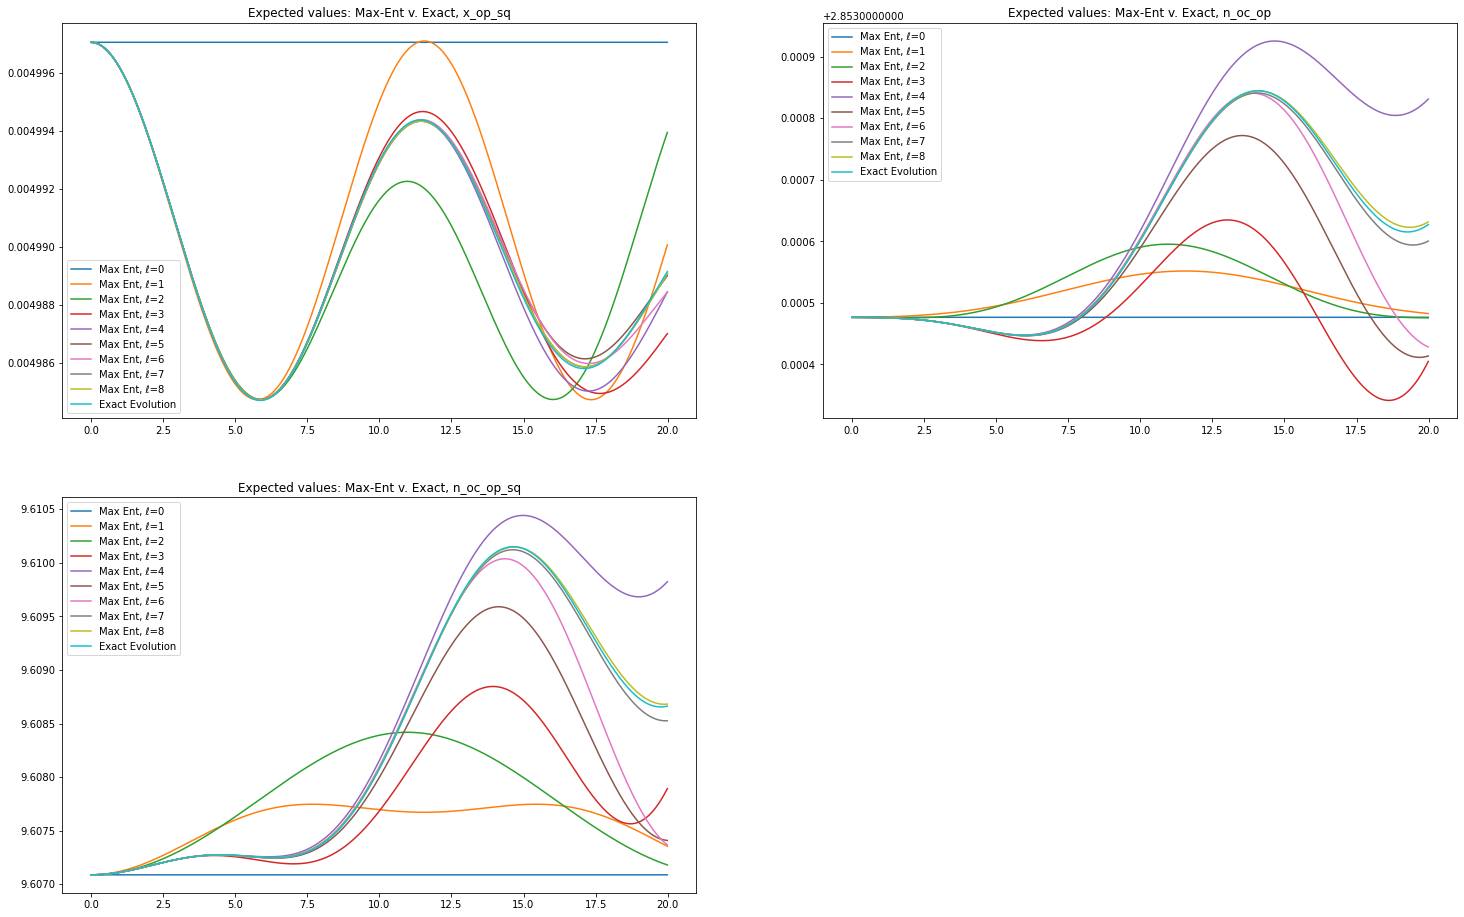

In [54]:
ts = np.linspace(0, 20, 1500)

resultados = rme.multiple_MaxEnt_evs(Hamiltonian = H_H, fixed_ops_list = calB_basis_0, range_HierarchBases_dims = depth_parameters,
                                          temp_ref = temp_ref, temp_rho = temp,
                                          rho0 = None, custom_ref_state = rho_ref, Kref = K_ref, coeff_list = coeff_basis_t0,
                                          generating_operator = cl_ops["x_op"],
                                                     init_coeff_list = all_coeff_list,
                                                     timespan = ts, label_ops = subset_label_ops,
                                                     observables = list(subset_of_observables.values()),
                                                     rho_ref_equal_rho0 = False)

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                         timespan = ts,
                         no_cols_desired = 2,
                         multiple_evolutions = resultados,
                         range_of_temps_or_dims = range_derived_series_orders,
                                          plot_var_HierarchBases_dim = True)

In [55]:
resultados["all_init_configs"]["init_configs_MaxEnt3"]["Gram matrix"]

Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[ 1.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j ...  0.-0.j -0.+0.j  0.-0.j]
 [ 0.+0.j  0.+0.j  1.+0.j ...  0.-0.j  0.+0.j  0.-0.j]
 ...
 [ 0.+0.j  0.-0.j  0.-0.j ...  1.+0.j  0.-0.j  0.+0.j]
 [ 0.+0.j -0.+0.j  0.+0.j ...  0.-0.j  1.+0.j  0.-0.j]
 [ 0.+0.j  0.-0.j  0.-0.j ...  0.+0.j  0.-0.j  1.+0.j]]

In [10]:
phi0_3 = resultados["all_max_ent_evs"]["res_evs_MaxEnt3"]["Coeff_ev"][0]
phi0_6 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["Coeff_ev"][0]

In [11]:
for i in phi0_3:
    print(i.real)

-0.050063348604898056
0.211318835780434
-6.264122147085077e-05
0.07051405905652952
0.0
1.3248950547772864e-16
0.0


In [12]:
for i in phi0_6:
    if i > 1e-5:
        print(i.real)
    else:
        print(0)

0
0.211318835780434
0
0.07051405905652952
0
0
0
0
0
0


In [13]:
rho_ref0 = resultados["all_init_configs"]["init_configs_MaxEnt0"]["rho_ref"]
rho_ref1 = resultados["all_init_configs"]["init_configs_MaxEnt1"]["rho_ref"]
rho_ref2 = resultados["all_init_configs"]["init_configs_MaxEnt2"]["rho_ref"]
rho_ref3 = resultados["all_init_configs"]["init_configs_MaxEnt3"]["rho_ref"]
rho_ref4 = resultados["all_init_configs"]["init_configs_MaxEnt4"]["rho_ref"]
rho_ref5 = resultados["all_init_configs"]["init_configs_MaxEnt5"]["rho_ref"]
rho_ref6 = resultados["all_init_configs"]["init_configs_MaxEnt6"]["rho_ref"]
rho_ref7 = resultados["all_init_configs"]["init_configs_MaxEnt7"]["rho_ref"]

In [14]:
rho_ref0 == rho_ref1 == rho_ref2 == rho_ref3 == rho_ref4 == rho_ref5 == rho_ref6 == rho_ref7

True

In [15]:
rho0_ell0 = resultados["all_init_configs"]["init_configs_MaxEnt0"]["rho0"]
rho0_ell1 = resultados["all_init_configs"]["init_configs_MaxEnt1"]["rho0"]
rho0_ell2 = resultados["all_init_configs"]["init_configs_MaxEnt2"]["rho0"]
rho0_ell3 = resultados["all_init_configs"]["init_configs_MaxEnt3"]["rho0"]
rho0_ell4 = resultados["all_init_configs"]["init_configs_MaxEnt4"]["rho0"]
rho0_ell5 = resultados["all_init_configs"]["init_configs_MaxEnt5"]["rho0"]
rho0_ell6 = resultados["all_init_configs"]["init_configs_MaxEnt6"]["rho0"]
rho0_ell7 = resultados["all_init_configs"]["init_configs_MaxEnt7"]["rho0"]

In [16]:
rho0_ell0 == rho0_ell1 == rho0_ell2 == rho0_ell3 == rho0_ell4 == rho0_ell5 == rho0_ell6 == rho0_ell7

True

In [17]:
rho_exact = resultados["res_exact"]["res_exact_MaxEnt8"].states
sigmat0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["State_ev"]
sigmat1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["State_ev"]
sigmat2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["State_ev"]
sigmat3 = resultados["all_max_ent_evs"]["res_evs_MaxEnt3"]["State_ev"]
sigmat4 = resultados["all_max_ent_evs"]["res_evs_MaxEnt4"]["State_ev"]
sigmat5 = resultados["all_max_ent_evs"]["res_evs_MaxEnt5"]["State_ev"]
sigmat6 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["State_ev"]
sigmat7 = resultados["all_max_ent_evs"]["res_evs_MaxEnt7"]["State_ev"]

In [30]:
rho_vs_sigma0 = [np.linalg.norm(rho_exact[t] - sigmat0[t], np.inf) / t**0 for t in range(len(sigmat1))]
rho_vs_sigma1 = [np.linalg.norm(rho_exact[t] - sigmat1[t], np.inf) / t**1 for t in range(len(sigmat1))]
rho_vs_sigma2 = [np.linalg.norm(rho_exact[t] - sigmat2[t], np.inf) / t**2 for t in range(len(sigmat1))]
rho_vs_sigma3 = [np.linalg.norm(rho_exact[t] - sigmat3[t], np.inf) / t**3 for t in range(len(sigmat1))]
rho_vs_sigma4 = [np.linalg.norm(rho_exact[t] - sigmat4[t], np.inf) / t**4 for t in range(len(sigmat1))]
rho_vs_sigma5 = [np.linalg.norm(rho_exact[t] - sigmat5[t], np.inf) / t**5 for t in range(len(sigmat1))]
rho_vs_sigma6 = [np.linalg.norm(rho_exact[t] - sigmat6[t], np.inf) / t**6 for t in range(len(sigmat1))]
rho_vs_sigma7 = [np.linalg.norm(rho_exact[t] - sigmat7[t], np.inf) / t**7 for t in range(len(sigmat1))]
#rho_vs_sigma8 = [np.linalg.norm(rho_exact[t] - sigmat8[t]) for t in range(len(sigmat1))]
rho_vs_all_sigmas = [rho_vs_sigma1, rho_vs_sigma2, rho_vs_sigma3, rho_vs_sigma4, rho_vs_sigma5, rho_vs_sigma6, rho_vs_sigma7]#, rho_vs_sigma8]

C:\Users\tomas\AppData\Local\Temp\ipykernel_20828\3791441992.py:2: RuntimeWarning: invalid value encountered in double_scalars
  rho_vs_sigma1 = [np.linalg.norm(rho_exact[t] - sigmat1[t], np.inf) / t**1 for t in range(len(sigmat1))]
C:\Users\tomas\AppData\Local\Temp\ipykernel_20828\3791441992.py:3: RuntimeWarning: invalid value encountered in double_scalars
  rho_vs_sigma2 = [np.linalg.norm(rho_exact[t] - sigmat2[t], np.inf) / t**2 for t in range(len(sigmat1))]
C:\Users\tomas\AppData\Local\Temp\ipykernel_20828\3791441992.py:4: RuntimeWarning: invalid value encountered in double_scalars
  rho_vs_sigma3 = [np.linalg.norm(rho_exact[t] - sigmat3[t], np.inf) / t**3 for t in range(len(sigmat1))]
C:\Users\tomas\AppData\Local\Temp\ipykernel_20828\3791441992.py:5: RuntimeWarning: invalid value encountered in double_scalars
  rho_vs_sigma4 = [np.linalg.norm(rho_exact[t] - sigmat4[t], np.inf) / t**4 for t in range(len(sigmat1))]
C:\Users\tomas\AppData\Local\Temp\ipykernel_20828\3791441992.py:6: R

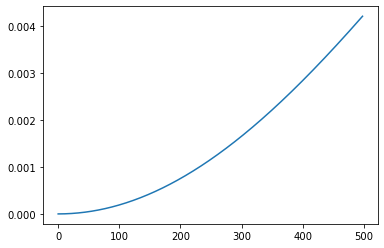

In [31]:
sigmat = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["State_ev"]

exact_v_ME = [np.linalg.norm(sigmat1[t] - rho_exact[t]) for t in range(len(sigmat3))]

plt.plot(exact_v_ME)

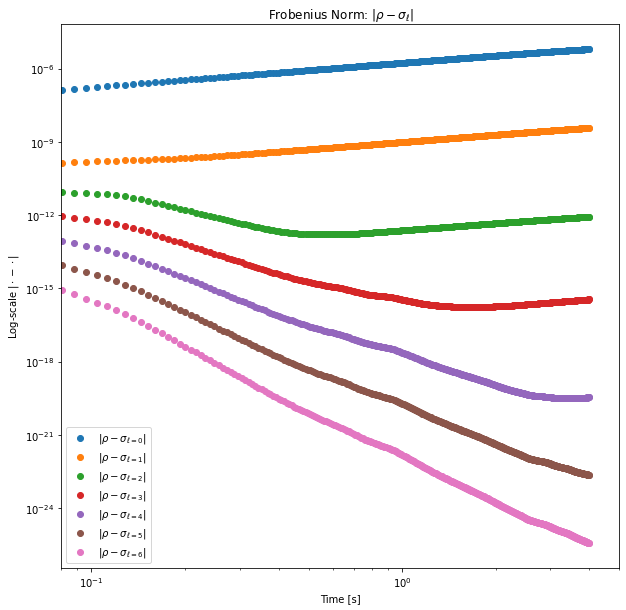

In [32]:
fig0, ax0 = plt.subplots(figsize=(10,10))

for n in range(len(rho_vs_all_sigmas)):
    plt.scatter(ts[:-1], rho_vs_all_sigmas[n], label = r'$|\rho - \sigma_{\ell = {%d}}|$' %n)

plt.xlim(8e-2, 5e0)
ax0.legend(loc=0)
ax0.set_xlabel(r'Time [s]')
ax0.set_ylabel(r'Log-scale $|\cdot - \cdot|$')
ax0.set_title(r'Frobenius Norm: $|\rho - \sigma_{\ell}|$')

plt.xscale('log')
plt.yscale('log')

In [58]:
avsg_xop_sq_exact = resultados["res_exact"]['res_exact_MaxEnt8'].expect[0][:-1]
avgs_xop_sq_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][0]
avgs_xop_sq_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][0]
avgs_xop_sq_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][0]
avgs_xop_sq_HB3 = resultados["all_max_ent_evs"]["res_evs_MaxEnt3"]["Avgs"][0]
avgs_xop_sq_HB4 = resultados["all_max_ent_evs"]["res_evs_MaxEnt4"]["Avgs"][0]
avgs_xop_sq_HB5 = resultados["all_max_ent_evs"]["res_evs_MaxEnt5"]["Avgs"][0]
avgs_xop_sq_HB6 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["Avgs"][0]

avgs_xop_sq_HB7 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["Avgs"][0]
avgs_xop_sq_HB8 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["Avgs"][0]

freq_fft = np.fft.fftfreq(ts.shape[-1])
freq_plot = freq_fft
freqs_fft_avgs_x_op_exact = np.fft.fft(avsg_xop_sq_exact)[1:]
freqs_fft_avgs_x_op_hb1 = np.fft.fft(avgs_xop_sq_HB1)[1:]
freqs_fft_avgs_x_op_hb3 = np.fft.fft(avgs_xop_sq_HB3)[1:]
freqs_fft_avgs_x_op_hb6 = np.fft.fft(avgs_xop_sq_HB6)[1:]
freqs_fft_avgs_x_op_hb8 = np.fft.fft(avgs_xop_sq_HB7)[1:]

freqs_fft_avgs_all = [freqs_fft_avgs_x_op_hb1, freqs_fft_avgs_x_op_hb3, freqs_fft_avgs_x_op_hb6, freqs_fft_avgs_x_op_hb8]

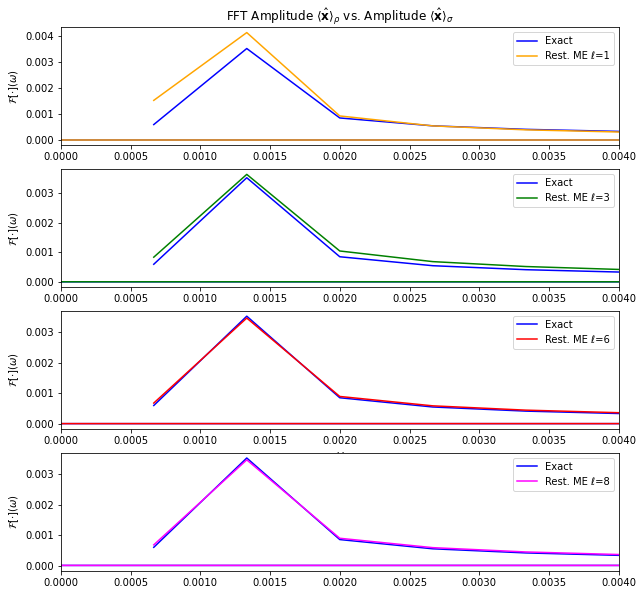

In [59]:
HB_dims = [1,3,6,8]
Tot = 4; Cols = 1
Rows = Tot // Cols 
if Tot % Cols != 0:
    Rows += 1
Position = range(1,Tot + 1)
fig = plt.figure(figsize=(10, 10))
colors = ["orange", "green", "red", "magenta", "yellow"]

for k in range(Tot):
    if k == 1:
        ax.set_title(r'FFT Amplitude $\langle \hat{\bf x} \rangle_{\rho}$ vs. Amplitude $\langle \hat{\bf x} \rangle_{\sigma}$')  
    ax = fig.add_subplot(Rows, Cols, Position[k])
    ax.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_x_op_exact.real + 1j * freqs_fft_avgs_x_op_exact.imag), color = "blue", label = "Exact")
    ax.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_all[k].real + 1j * freqs_fft_avgs_all[k].imag), color = colors[k], label = "Rest. ME ℓ=" + str(HB_dims[k]))
    plt.ylabel(r'${\cal F} [\cdot](\omega)$')
    if k == 2: 
        plt.xlabel(r'$\omega$')
    plt.xlim(0, .004)
    ax.legend(loc=0)

# Como estaba antes

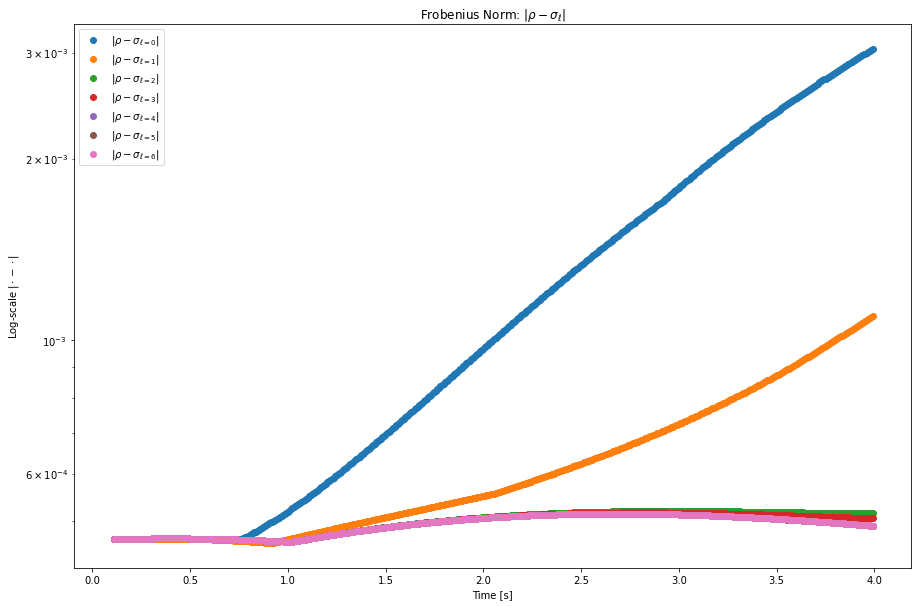

In [84]:
fig0, ax0 = plt.subplots(figsize=(15,10))

for n in range(len(rho_vs_all_sigmas)):
    plt.scatter(ts[:-1], rho_vs_all_sigmas[n], label = r'$|\rho - \sigma_{\ell = {%d}}|$' %n)

#plt.xlim(0, 1)
ax0.legend(loc=0)
ax0.set_xlabel(r'Time [s]')
ax0.set_ylabel(r'Log-scale $|\cdot - \cdot|$')
ax0.set_title(r'Frobenius Norm: $|\rho - \sigma_{\ell}|$')
plt.yscale('log')